In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix
import os
import random
import gc

In [2]:
metrics = np.load('matrices/model_outputs_collection.npy')

In [3]:
adverse_indices = torch.tensor([   7,   24,   25,   60,   72,   73,   86,   98,  107,  110,  122,  146,
          159,  164,  180,  197,  206,  207,  209,  220,  229,  231,  248,  255,
          269,  296,  303,  325,  368,  382,  387,  399,  427,  455,  465,  468,
          504,  515,  533,  565,  579,  584,  593,  611,  616,  637,  640,  655,
          670,  671,  678,  689,  705,  712,  724,  730,  736,  755,  758,  771,
          773,  778,  792,  823,  829,  838,  851,  870,  874,  876,  878,  895,
          896,  926,  942,  948,  961,  994, 1010, 1030, 1055, 1060, 1074, 1093,
         1099, 1117, 1131, 1143, 1160, 1165, 1179, 1191, 1195, 1203, 1208, 1213,
         1214, 1220, 1228, 1232, 1235, 1251, 1269, 1280, 1283, 1287, 1311, 1329,
         1340, 1347, 1348, 1360, 1379, 1380, 1387, 1394, 1397, 1412, 1423, 1428,
         1461, 1486, 1489, 1493, 1494, 1495, 1503, 1510, 1514, 1554, 1555, 1570,
         1582, 1613, 1652, 1655, 1679, 1684, 1687, 1696, 1697, 1717, 1725, 1737,
         1761, 1771, 1782, 1786, 1788, 1798, 1804, 1817, 1847, 1859, 1873, 1876,
         1911, 1927, 1930, 1931, 1960, 1961, 1965, 1966, 1967, 1968, 1972, 1985,
         1987, 1998, 2000, 2017, 2020, 2031, 2035, 2037, 2054, 2056, 2073, 2099,
         2116, 2144, 2172, 2205, 2220, 2223])

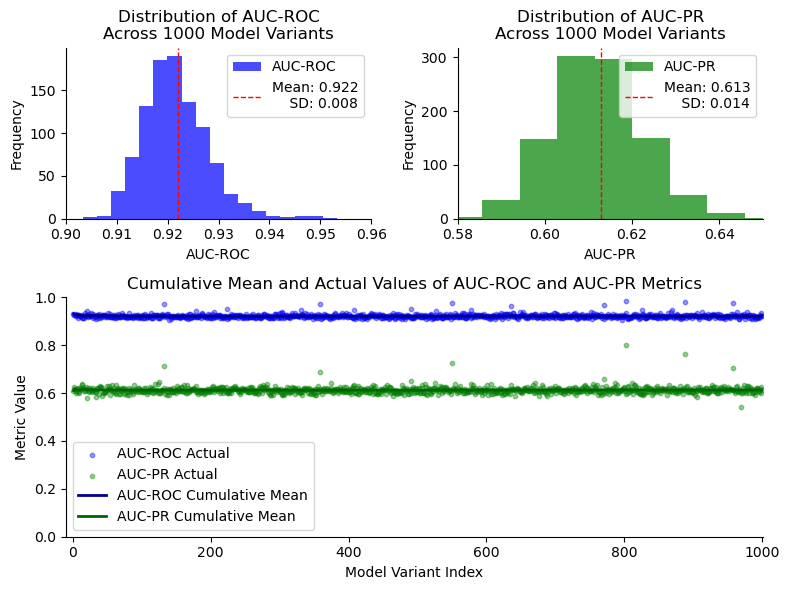

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_auc_score, average_precision_score

# === Step 1: Recalculate AUC Metrics from updated_stacked_np ===
# Assume updated_stacked_np is your (1000,2231) numpy array of updated probabilities.
# Assume positive_indices is defined (an array of indices for the 186 positive samples).
num_models, num_samples = metrics.shape
positive_indices = adverse_indices

# Create ground truth labels: 1 for positive samples, 0 for negative samples.
labels = np.zeros(num_samples)
labels[positive_indices] = 1

# For each model (each row in updated_stacked_np), compute AUC-ROC and AUC-PR.
auc_roc_list = []
auc_pr_list = []
for i in range(num_models):
    preds = metrics[i]
    auc_roc_list.append(roc_auc_score(labels, preds))
    auc_pr_list.append(average_precision_score(labels, preds))

auc_roc_arr_best = np.array(auc_roc_list)
auc_pr_arr_best = np.array(auc_pr_list)

# === Step 2: Compute Overall and Running (Cumulative) Means ===
mean_auc_roc = np.mean(auc_roc_arr_best)
mean_auc_pr = np.mean(auc_pr_arr_best)

stdev_auc_roc = np.std(auc_roc_arr_best)
stdev_auc_pr = np.std(auc_pr_arr_best)

running_mean_roc = np.cumsum(auc_roc_arr_best) / np.arange(1, len(auc_roc_arr_best) + 1)
running_mean_pr  = np.cumsum(auc_pr_arr_best)  / np.arange(1, len(auc_roc_arr_best) + 1)

models = np.arange(1, len(auc_roc_arr_best) + 1)

# === Step 3: Plotting with GridSpec Layout ===
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.4])

# Top left: Histogram for AUC-ROC
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(auc_roc_arr_best, bins=30, alpha=0.7, label="AUC-ROC", color='blue')
ax1.set_xlabel("AUC-ROC")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of AUC-ROC\nAcross 1000 Model Variants")
ax1.set_xlim(0.9, 0.96)
ax1.axvline(mean_auc_roc, color='red', linestyle='dashed', linewidth=1,
            label=f"Mean: {mean_auc_roc:.3f}\n    SD: {stdev_auc_roc:.3f}")
ax1.legend()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Top right: Histogram for AUC-PR
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(auc_pr_arr_best, bins=30, alpha=0.7, label="AUC-PR", color='green')
ax2.set_xlabel("AUC-PR")
ax2.set_ylabel("Frequency")
ax2.set_title("Distribution of AUC-PR\nAcross 1000 Model Variants")
ax2.set_xlim(0.58, 0.65)
ax2.axvline(mean_auc_pr, color='red', linestyle='dashed', linewidth=1,
            label=f"Mean: {mean_auc_pr:.3f}\n    SD: {stdev_auc_pr:.3f}")
ax2.legend()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Bottom spanning both columns: Running mean with actual values.
ax3 = fig.add_subplot(gs[1, :])

ax3.scatter(models, auc_roc_arr_best, color='blue', alpha=0.4, s=10, label="AUC-ROC Actual")
ax3.scatter(models, auc_pr_arr_best, color='green', alpha=0.4, s=10, label="AUC-PR Actual")

# Overlay running (cumulative) mean lines.
ax3.plot(models, running_mean_roc, color='darkblue', linewidth=2, label="AUC-ROC Cumulative Mean")
ax3.plot(models, running_mean_pr, color='darkgreen', linewidth=2, label="AUC-PR Cumulative Mean")

ax3.set_xlabel("Model Variant Index")
ax3.set_ylabel("Metric Value")
ax3.set_title("Cumulative Mean and Actual Values of AUC-ROC and AUC-PR Metrics")
# If desired, you can uncomment the next line to use a symlog scale on the x-axis:
# ax3.set_xscale("symlog", linthresh=1)
ax3.legend()
ax3.set_ylim(0.0, 1.0)
ax3.set_xlim(-10, 1001)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plt.tight_layout()
# plt.show()
plt.savefig('Model_metrics.png', dpi=500, bbox_inches='tight')